In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import requests
import tarfile
import gc # For garbage collection and memory management
import matplotlib.cm as cm # For colormap handling
import pandas as pd # For saving to CSV

# Nilearn for brain image plotting and datasets
from nilearn import plotting, datasets

# tslearn for K-Means clustering (DTW K-Means)
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from tslearn.barycenters import dtw_barycenter_averaging # Make sure this is imported

# --- Basic parameters ---
HCP_DIR = "./DATA" # Directory to store downloaded and extracted HCP data
plots_output_dir = "./brain_plots" # Directory to store generated plots
csv_output_dir = "./csv_data" # Directory to store generated CSV files

# Ensure directories exist
for directory in [HCP_DIR, plots_output_dir, csv_output_dir]:
    if not os.path.isdir(directory):
        os.mkdir(directory)
        print(f"Created directory: {directory}")

print(f"Brain plots will be saved to: {plots_output_dir}")
print(f"CSV data will be saved to: {csv_output_dir}")

N_PARCELS = 360 # Number of parcels in the Glasser Atlas
TR = 0.72 # Repetition Time (TR) for HCP fMRI data
N_RUNS_REST = 4 # Number of resting-state runs per subject
N_RUNS_TASK = 2 # Number of task runs per subject (e.g., WM)
N_SUBJECTS_FOR_GROUP_ANALYSIS = 50 # How many subjects to include in the group average K-means

# BOLD run names (including WM task)
BOLD_NAMES = [
    "rfMRI_REST1_LR", "rfMRI_REST1_RL",
    "rfMRI_REST2_LR", "rfMRI_REST2_RL",
    "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
    "tfMRI_WM_RL", "tfMRI_WM_LR",
    "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
    "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
    "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
    "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
    "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# --- Download and Extract Data ---
print("\n--- Checking and downloading necessary data files ---")
fnames_to_check = ["hcp_rest.tgz", "hcp_task.tgz", "atlas.npz"]
urls_to_check = {
    "hcp_rest.tgz": "https://osf.io/bqp7m/download",
    "hcp_task.tgz": "https://osf.io/s4h8j/download",
    "atlas.npz": "https://osf.io/j5kuc/download"
}

for fname in fnames_to_check:
    url = urls_to_check.get(fname)
    if not url:
        print(f"Error: URL for {fname} not found in urls_to_check map. Skipping download.")
        continue

    local_path = os.path.join(".", fname) # Check in current directory
    if not os.path.isfile(local_path):
        try:
            print(f"Downloading {fname} from {url}...")
            r = requests.get(url, stream=True)
            r.raise_for_status()
        except requests.exceptions.RequestException as e:
            print(f"!!! Failed to download {fname}: {e} !!! Please check your internet connection or URL.")
        else:
            with open(local_path, "wb") as fid:
                for chunk in r.iter_content(chunk_size=8192):
                    fid.write(chunk)
            print(f"Download of {fname} completed!")
    else:
        print(f"'{fname}' already exists, skipping download.")

print("\n--- Extracting data ---")
extraction_targets = {
    "hcp_rest.tgz": os.path.join(HCP_DIR, "hcp_rest"),
    "hcp_task.tgz": os.path.join(HCP_DIR, "hcp_task"),
}

for tgz_file, extract_dir in extraction_targets.items():
    local_tgz_path = os.path.join(".", tgz_file)
    if os.path.isfile(local_tgz_path):
        if not os.path.exists(extract_dir):
            print(f"Extracting {tgz_file} to {extract_dir}...")
            try:
                with tarfile.open(local_tgz_path, "r:gz") as tar:
                    tar.extractall(path=HCP_DIR)
                print(f"Extraction of {tgz_file} completed!")
            except tarfile.ReadError as e:
                print(f"!!! Failed to extract {tgz_file}: {e} !!! Ensure download was complete/not corrupted.")
        else:
            print(f"{extract_dir} already exists, skipping extraction for {tgz_file}.")
    else:
        print(f"'{tgz_file}' not found, skipping extraction.")

# --- Load Atlas Information and fsaverage surface ---
print("\n--- Loading atlas and fsaverage surface information ---")

try:
    with np.load("atlas.npz") as dobj:
        atlas = dict(**dobj)
    print("Atlas information (Glasser parcels and hemisphere labels) loaded.")
except FileNotFoundError:
    print("Error: atlas.npz not found. Please ensure it is in the current directory or downloaded.")
    exit()

fsaverage = datasets.fetch_surf_fsaverage()
print("fsaverage surface data loaded.")


# --- Helper functions (from your original code, adapted as needed) ---

def get_image_ids(name):
    """Returns the BOLD run IDs for a given task/rest name."""
    run_ids = [i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code]
    if not run_ids:
        raise ValueError(f"Found no data for '{name}'")
    return run_ids

# Renamed 'dir' to 'data_dir' for consistency
def load_single_timeseries(subject, bold_run, data_dir, remove_mean=True):
    """Loads a single BOLD time series for a given subject and run."""
    bold_path = os.path.join(data_dir, "subjects", str(subject), "timeseries")
    bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
    full_path = os.path.join(bold_path, bold_file)
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"Timeseries file not found: {full_path}")
    ts = np.load(full_path)
    if remove_mean:
        ts -= ts.mean(axis=1, keepdims=True)
    return ts

# Renamed 'dir' to 'data_dir' for consistency
def load_timeseries(subject, name, data_dir, runs=None, concat=True, remove_mean=True):
    """Loads and optionally concatenates multiple BOLD time series for a subject and condition."""
    if runs is None:
        runs_count = N_RUNS_REST if name == "rest" else N_RUNS_TASK
        runs = range(runs_count)
    elif isinstance(runs, int):
        runs = [runs]

    offset = get_image_ids(name)[0]

    # Pass data_dir consistently here
    bold_data = [load_single_timeseries(subject, offset + run, data_dir, remove_mean) for run in runs]

    if concat:
        bold_data = np.concatenate(bold_data, axis=-1)
    return bold_data

def load_evs(subject, name, condition, data_dir):
    """Loads event (EV) data for a specific task and condition."""
    evs = []
    for id in get_image_ids(name):
        task_key = BOLD_NAMES[id - 1]
        ev_file = os.path.join(data_dir, "subjects", str(subject), "EVs", task_key, f"{condition}.txt")
        if not os.path.exists(ev_file):
            # print(f"Warning: EV file not found for subject {subject}, task {task_key}, condition {condition}: {ev_file}")
            continue # Skip if EV file doesn't exist
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
        evs.append(ev)
    return evs

def condition_frames(run_evs, skip=0):
    """Calculates frame indices corresponding to a specific condition."""
    frames_list = []
    for ev in run_evs:
        start = np.floor(ev["onset"] / TR).astype(int)
        duration = np.ceil(ev["duration"] / TR).astype(int)
        frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]
        frames_list.append(np.concatenate(frames))
    return frames_list

def plot_brain_surface_data(data_to_plot, atlas_labels, title, vmin, vmax, cmap, output_filename, colorbar_label=""):
    """
    Plots data on the brain surface (both hemispheres).

    Parameters:
    - data_to_plot (np.ndarray): 1D array of shape (N_PARCELS,) with data for each parcel.
    - atlas_labels (dict): Dictionary from atlas.npz containing 'labels_L' and 'labels_R'.
    - title (str): Title for the plot.
    - vmin (float): Minimum value for the colorbar.
    - vmax (float): Maximum value for the colorbar.
    - cmap (str): Colormap to use (e.g., 'cold_hot', 'viridis').
    - output_filename (str): Name of the file to save the plot.
    - colorbar_label (str): Label for the colorbar.
    """
    fig = plt.figure(figsize=(12, 6))
    fig.suptitle(title, fontsize=16)

    # Left Hemisphere
    ax_left = fig.add_subplot(1, 2, 1, projection='3d')
    display_left = plotting.plot_surf_stat_map(
        fsaverage['infl_left'],
        data_to_plot[atlas_labels["labels_L"]],
        hemi='left',
        view='lateral',
        cmap=cmap,
        colorbar=True,
        bg_map=fsaverage['sulc_left'],
        title='Left Hemisphere',
        vmax=vmax, vmin=vmin,
        figure=fig,
        axes=ax_left
    )
    # Right Hemisphere
    ax_right = fig.add_subplot(1, 2, 2, projection='3d')
    display_right = plotting.plot_surf_stat_map(
        fsaverage['infl_right'],
        data_to_plot[atlas_labels["labels_R"]],
        hemi='right',
        view='lateral',
        cmap=cmap,
        colorbar=True,
        bg_map=fsaverage['sulc_right'],
        title='Right Hemisphere',
        vmax=vmax, vmin=vmin,
        figure=fig,
        axes=ax_right
    )

    # Add a single colorbar for the figure
    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6]) # [left, bottom, width, height]
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label(colorbar_label)

    plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for the colorbar
    plt.savefig(os.path.join(plots_output_dir, output_filename), dpi=300)
    plt.close(fig)
    print(f"Brain surface plot saved to: {os.path.join(plots_output_dir, output_filename)}")

# --- End Helper Functions ---


# --- Function to calculate subject-level brain states for a given condition ---
def calculate_subject_brain_states(subjects_list, condition_name, data_dir, task_condition=None):
    """
    Calculates the mean BOLD brain state vector for each subject for a given condition.
    A brain state here is the average BOLD signal across time for each parcel.

    Parameters:
    - subjects_list (list): List of subject IDs.
    - condition_name (str): 'rest' or task name (e.g., 'WM').
    - data_dir (str): Directory where the HCP data for the condition is located.
    - task_condition (str, optional): Specific task condition (e.g., '2bk_cor') if condition_name is a task.

    Returns:
    - all_subjects_brain_states (list): List of (N_PARCELS,) numpy arrays, one per subject.
    - valid_subjects_indices (list): List of original subject indices that were successfully processed.
    """
    print(f"Collecting brain states for condition: {condition_name} ({task_condition if task_condition else 'all runs'})")
    all_subjects_brain_states = []
    valid_subjects_indices = []

    for i, subject_idx in enumerate(subjects_list):
        # print(f"  Processing Subject {subject_idx} for {condition_name}...") # Uncomment for detailed progress
        try:
            if condition_name == "rest":
                # Pass data_dir consistently
                ts_subject = load_timeseries(subject=subject_idx,
                                             name="rest",
                                             data_dir=data_dir, # Corrected parameter name
                                             concat=True,
                                             remove_mean=True)
            else: # For tasks like WM
                # Pass data_dir consistently
                ts_subject_runs = load_timeseries(subject=subject_idx,
                                                  name=condition_name,
                                                  data_dir=data_dir, # Corrected parameter name
                                                  concat=False, # Load runs separately to apply EV filtering
                                                  remove_mean=True)
                # Pass data_dir consistently
                evs_subject_condition = load_evs(subject_idx, condition_name, task_condition, data_dir)
                if not evs_subject_condition:
                    print(f"    Warning: No EV data found for Subject {subject_idx}, condition '{condition_name}', task_condition '{task_condition}'. Skipping.")
                    continue

                frames_list_for_subject = condition_frames(evs_subject_condition, skip=0)

                # Concatenate BOLD data only for frames relevant to the condition
                condition_ts_segments = []
                for run_idx, run_ts_data in enumerate(ts_subject_runs):
                    if run_idx < len(frames_list_for_subject): # Ensure there are EV frames for this run
                        run_frames = frames_list_for_subject[run_idx]
                        run_frames = run_frames[run_frames < run_ts_data.shape[1]] # Ensure frames are within bounds
                        if run_frames.size > 0:
                            condition_ts_segments.append(run_ts_data[:, run_frames])

                if not condition_ts_segments:
                    print(f"    Warning: No valid BOLD data segments for condition '{task_condition}' for Subject {subject_idx}. Skipping.")
                    continue
                ts_subject = np.concatenate(condition_ts_segments, axis=-1)

            if ts_subject.shape[1] == 0:
                print(f"    Warning: Subject {subject_idx} has no time points for {condition_name} after filtering. Skipping.")
                continue

            # Calculate the mean BOLD across time for each parcel for this subject
            brain_state_subject = np.mean(ts_subject, axis=1) # Shape (N_PARCELS,)
            all_subjects_brain_states.append(brain_state_subject)
            valid_subjects_indices.append(subject_idx) # Keep track of which subjects were included

            del ts_subject
            gc.collect()

        except FileNotFoundError as fnf_e:
            print(f"    Warning: Data not found for Subject {subject_idx} for {condition_name}: {fnf_e}. Skipping.")
        except Exception as e:
            print(f"    Error processing Subject {subject_idx} for {condition_name}: {e}. Skipping.")
            continue

    print(f"Successfully collected brain states for {len(all_subjects_brain_states)} out of {len(subjects_list)} subjects.")
    return all_subjects_brain_states, valid_subjects_indices


# --- Function to perform K-Means clustering and visualize barycenters ---
def cluster_and_visualize_brain_states(all_subjects_brain_states, valid_subjects_indices, chosen_k, analysis_name, condition_label):
    """
    Performs K-Means clustering on subject-level brain states and visualizes the barycenters.

    Parameters:
    - all_subjects_brain_states (list): List of (N_PARCELS,) numpy arrays, one per subject.
    - valid_subjects_indices (list): List of original subject indices included.
    - chosen_k (int): Number of clusters.
    - analysis_name (str): Identifier for saving plots (e.g., 'resting_state').
    - condition_label (str): Human-readable label for titles (e.g., 'Resting State', 'WM 2-Back Correct').
    """
    if not all_subjects_brain_states:
        print(f"No brain states available for clustering for {condition_label}. Skipping clustering.")
        return

    # Convert list of brain states to a NumPy array for clustering
    # Shape will be (N_SUBJECTS, N_PARCELS)
    brain_states_array = np.array(all_subjects_brain_states)
    print(f"Shape of collected subject-level brain states for clustering: {brain_states_array.shape}")

    # For tslearn, data needs to be (n_samples, n_timestamps, n_features).
    # Here, n_samples is N_SUBJECTS, n_timestamps is N_PARCELS, and n_features is 1 (univariate 'brain state' vector)
    # The 'time' dimension for clustering is the parcels themselves.
    brain_states_for_kmeans = brain_states_array[:, :, np.newaxis]
    print(f"Shape of brain states for tslearn K-Means: {brain_states_for_kmeans.shape}")

    print(f"\nPerforming K-Means Clustering (k={chosen_k}) on {len(all_subjects_brain_states)} subject {condition_label} brain states...")

    try:
        # Using dtw_barycenter_averaging as the barycenter computation for DTW K-Means
        km = TimeSeriesKMeans(n_clusters=chosen_k,
                              metric="dtw",
                              max_iter=10,
                              random_state=42, # Using a fixed random_state for reproducibility
                              n_init=3, # Run K-Means multiple times with different centroids seeds
                              n_jobs=-1 # Use all available CPU cores
                             )
        km.fit(brain_states_for_kmeans)
        print(f"  Clustering of subject {condition_label} brain states complete.")

        # Get cluster assignments for each subject
        subject_cluster_labels = km.labels_
        print(f"Subject cluster assignments (labels_) shape: {subject_cluster_labels.shape}")
        print(f"Unique subject cluster IDs: {np.unique(subject_cluster_labels)}")

        # Get the barycenters (mean brain state for each cluster of subjects)
        barycenters = km.cluster_centers_
        barycenters_reshaped = barycenters.squeeze() # Remove the single-feature dimension
        print(f"Shape of barycenters (mean brain states for each cluster): {barycenters_reshaped.shape}")

        # --- Save Subject Cluster Assignments to CSV ---
        print(f"\nSaving subject cluster assignments to CSV...")
        try:
            df_subject_clusters = pd.DataFrame({
                'Subject_ID': valid_subjects_indices,
                f'Cluster_ID_{analysis_name}': subject_cluster_labels
            })
            csv_file_path_assignments = os.path.join(csv_output_dir, f'subject_cluster_assignments_{analysis_name}_k{chosen_k}.csv')
            df_subject_clusters.to_csv(csv_file_path_assignments, index=False)
            print(f"Subject cluster assignments saved to '{csv_file_path_assignments}'.")
        except Exception as e:
            print(f"Error saving subject cluster assignments to CSV: {e}")


        # --- Plot Barycenter Brain States on Brain Surface ---
        print(f"\nPlotting barycenter brain states for k={chosen_k} clusters for {condition_label}...")
        try:
            # Create a combined figure for all barycenters
            # We'll arrange them as rows of (Left Hemi, Right Hemi)
            fig_bary_brains, axes_bary_brains = plt.subplots(chosen_k, 2, figsize=(16, 4 * chosen_k),
                                                              subplot_kw={'projection': '3d'})
            fig_bary_brains.suptitle(f'{condition_label} Brain State Barycenters (k={chosen_k})', fontsize=16)

            for i in range(chosen_k):
                current_barycenter_state = barycenters_reshaped[i]
                vabs_max_bary = np.max(np.abs(current_barycenter_state))
                if vabs_max_bary == 0: # Avoid division by zero for colorbar if all values are 0
                    vabs_max_bary = 1e-12
                vmin_bary, vmax_bary = -vabs_max_bary, vabs_max_bary

                # Plot Left Hemisphere
                plotting.plot_surf_stat_map(
                    fsaverage['infl_left'],
                    current_barycenter_state[atlas["labels_L"]],
                    hemi='left',
                    view='lateral',
                    cmap='cold_hot',
                    colorbar=False,
                    bg_map=fsaverage['sulc_left'],
                    title=f'Cluster {i} - Left',
                    vmax=vmax_bary, vmin=vmin_bary,
                    figure=fig_bary_brains,
                    axes=axes_bary_brains[i, 0] if chosen_k > 1 else axes_bary_brains[0] # Handle single row case
                )

                # Plot Right Hemisphere
                plotting.plot_surf_stat_map(
                    fsaverage['infl_right'],
                    current_barycenter_state[atlas["labels_R"]],
                    hemi='right',
                    view='lateral',
                    cmap='cold_hot',
                    colorbar=False,
                    bg_map=fsaverage['sulc_right'],
                    title=f'Cluster {i} - Right',
                    vmax=vmax_bary, vmin=vmin_bary,
                    figure=fig_bary_brains,
                    axes=axes_bary_brains[i, 1] if chosen_k > 1 else axes_bary_brains[1] # Handle single row case
                )

                # Add a colorbar for each barycenter (row of plots)
                # Position: [left, bottom, width, height] relative to figure
                # These coordinates need careful tuning based on your overall figure size and subplot arrangement
                # A simple approximation for `bottom` based on row index:
                cbar_bottom = (chosen_k - 1 - i) * (1 / (chosen_k + 0.5)) + 0.05 # Adjust this for better vertical spacing
                cbar_ax_bary = fig_bary_brains.add_axes([0.90, cbar_bottom, 0.02, (0.8 / chosen_k) - 0.05]) # Adjusted for vertical
                norm_bary = plt.Normalize(vmin=vmin_bary, vmax=vmax_bary)
                sm_bary = cm.ScalarMappable(cmap='cold_hot', norm=norm_bary)
                sm_bary.set_array([])
                cbar_bary = fig_bary_brains.colorbar(sm_bary, cax=cbar_ax_bary)
                cbar_bary.set_label('Mean BOLD')

            fig_bary_brains.tight_layout(rect=[0.01, 0.01, 0.88, 0.95]) # Adjust rect to leave space for colorbars on right
            plt.savefig(os.path.join(plots_output_dir, f'{analysis_name}_barycenter_brain_states_k{chosen_k}.png'))
            plt.close(fig_bary_brains)
            print(f"Barycenter brain states plot saved to '{plots_output_dir}'.")

        except Exception as e:
            print(f"Error plotting barycenter brain states for {condition_label}: {e}")

        # --- Save Barycenter Values to CSV ---
        print(f"\nSaving barycenter values to CSV...")
        try:
            column_names = [f'Barycenter_{i}' for i in range(chosen_k)]
            df_barycenters = pd.DataFrame(barycenters_reshaped.T, columns=column_names)
            df_barycenters.index.name = 'Parcel_ID'
            csv_file_path_barycenters = os.path.join(csv_output_dir, f'{analysis_name}_barycenters_k{chosen_k}.csv')
            df_barycenters.to_csv(csv_file_path_barycenters)
            print(f"Barycenter values saved to '{csv_file_path_barycenters}'.")
        except Exception as e:
            print(f"Error saving barycenter values to CSV: {e}")

        # Move del statements inside the try block
        del barycenters, barycenters_reshaped

    except Exception as e:
        print(f"  An error occurred during K-Means clustering of {condition_label} brain states: {e}")

    del brain_states_array, brain_states_for_kmeans # Keep these outside the try block as they are assigned before fitting
    gc.collect()


# --- Main execution for Clustering Subject-Level Brain States ---
subjects_to_process = list(range(N_SUBJECTS_FOR_GROUP_ANALYSIS))
chosen_k_brain_states = 3 # You can experiment with different K values here

# --- Resting State Brain State Clustering ---
print("\n" + "="*80)
print("Starting K-Means Clustering on Subject-Level Resting-State Brain States")
print("="*80 + "\n")

resting_state_data_dir = os.path.join(HCP_DIR, "hcp_rest")
all_subjects_resting_brain_states, valid_resting_subjects = calculate_subject_brain_states(
    subjects_to_process, "rest", resting_state_data_dir
)
cluster_and_visualize_brain_states(
    all_subjects_resting_brain_states, valid_resting_subjects,
    chosen_k_brain_states, "resting_state", "Resting State"
)
print("\n" + "="*80)
print("Resting-State Brain State K-Means Clustering Completed.")
print("="*80 + "\n")

# --- WM Task Brain State Clustering ---
print("\n" + "="*80)
print("Starting K-Means Clustering on Subject-Level WM Task Brain States")
print("="*80 + "\n")

wm_task_data_dir = os.path.join(HCP_DIR, "hcp_task")
wm_task_condition = "2bk_cor" # Focusing on '2-back correct trials'

all_subjects_wm_brain_states, valid_wm_subjects = calculate_subject_brain_states(
    subjects_to_process, "WM", wm_task_data_dir, task_condition=wm_task_condition
)
cluster_and_visualize_brain_states(
    all_subjects_wm_brain_states, valid_wm_subjects,
    chosen_k_brain_states, "wm_task", f"WM Task ({wm_task_condition})"
)
print("\n" + "="*80)
print("WM Task Brain State K-Means Clustering Completed.")
print("="*80 + "\n")

print("\nAll analyses complete.")

Brain plots will be saved to: ./brain_plots
CSV data will be saved to: ./csv_data

--- Checking and downloading necessary data files ---
'hcp_rest.tgz' already exists, skipping download.
'hcp_task.tgz' already exists, skipping download.
'atlas.npz' already exists, skipping download.

--- Extracting data ---
./DATA/hcp_rest already exists, skipping extraction for hcp_rest.tgz.
./DATA/hcp_task already exists, skipping extraction for hcp_task.tgz.

--- Loading atlas and fsaverage surface information ---
Atlas information (Glasser parcels and hemisphere labels) loaded.
fsaverage surface data loaded.

Starting K-Means Clustering on Subject-Level Resting-State Brain States

Successfully collected brain states for 50 out of 50 subjects.
Shape of collected subject-level brain states for clustering: (50, 360)
Shape of brain states for tslearn K-Means: (50, 360, 1)

Performing K-Means Clustering (k=3) on 50 subject Resting State brain states...
  Clustering of subject Resting State brain states 

/tmp/ipython-input-14-936293181.py:411: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf_stat_map(
/tmp/ipython-input-14-936293181.py:426: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf_stat_map(
/tmp/ipython-input-14-936293181.py:452: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_bary_brains.tight_layout(rect=[0.01, 0.01, 0.88, 0.95]) # Adjust rect to leave space for colorbars on right


Barycenter brain states plot saved to './brain_plots'.

Saving barycenter values to CSV...
Barycenter values saved to './csv_data/resting_state_barycenters_k3.csv'.

Resting-State Brain State K-Means Clustering Completed.


Starting K-Means Clustering on Subject-Level WM Task Brain States

Successfully collected brain states for 50 out of 50 subjects.
Shape of collected subject-level brain states for clustering: (50, 360)
Shape of brain states for tslearn K-Means: (50, 360, 1)

Performing K-Means Clustering (k=3) on 50 subject WM Task (2bk_cor) brain states...
  Clustering of subject WM Task (2bk_cor) brain states complete.
Subject cluster assignments (labels_) shape: (50,)
Unique subject cluster IDs: [0 1 2]
Shape of barycenters (mean brain states for each cluster): (3, 360)

Saving subject cluster assignments to CSV...
Subject cluster assignments saved to './csv_data/subject_cluster_assignments_wm_task_k3.csv'.

Plotting barycenter brain states for k=3 clusters for WM Task (2bk_cor).

/tmp/ipython-input-14-936293181.py:411: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf_stat_map(
/tmp/ipython-input-14-936293181.py:426: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf_stat_map(
/tmp/ipython-input-14-936293181.py:452: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_bary_brains.tight_layout(rect=[0.01, 0.01, 0.88, 0.95]) # Adjust rect to leave space for colorbars on right


Barycenter brain states plot saved to './brain_plots'.

Saving barycenter values to CSV...
Barycenter values saved to './csv_data/wm_task_barycenters_k3.csv'.

WM Task Brain State K-Means Clustering Completed.


All analyses complete.


     WM_Cluster  Rest_Cluster  Spearman_rho   p_value
0  Barycenter_0  Barycenter_0      0.039825  0.451271
1  Barycenter_0  Barycenter_1      0.024112  0.648415
2  Barycenter_0  Barycenter_2      0.089695  0.089252
3  Barycenter_1  Barycenter_0      0.060845  0.249528
4  Barycenter_1  Barycenter_1      0.079589  0.131751
5  Barycenter_1  Barycenter_2      0.054012  0.306789
6  Barycenter_2  Barycenter_0      0.003017  0.954510
7  Barycenter_2  Barycenter_1      0.058815  0.265700
8  Barycenter_2  Barycenter_2      0.116659  0.026876


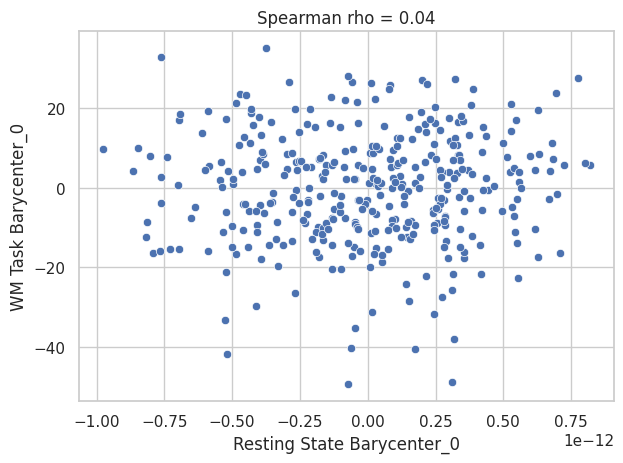

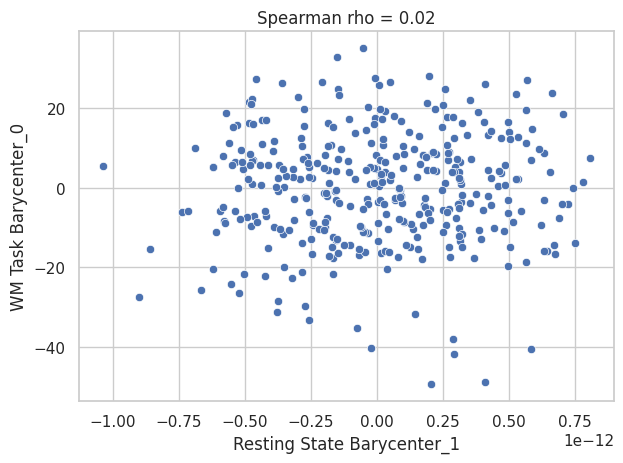

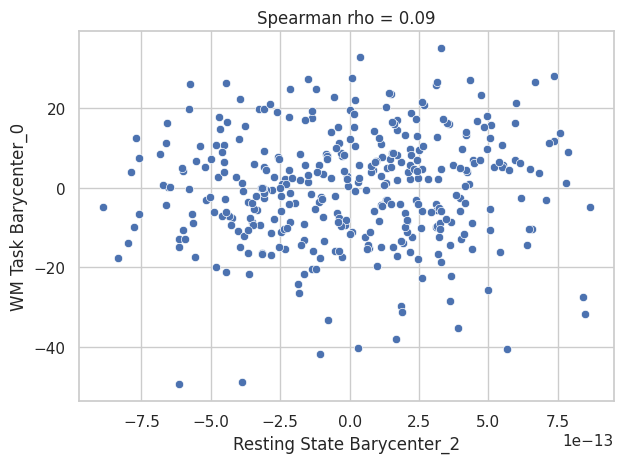

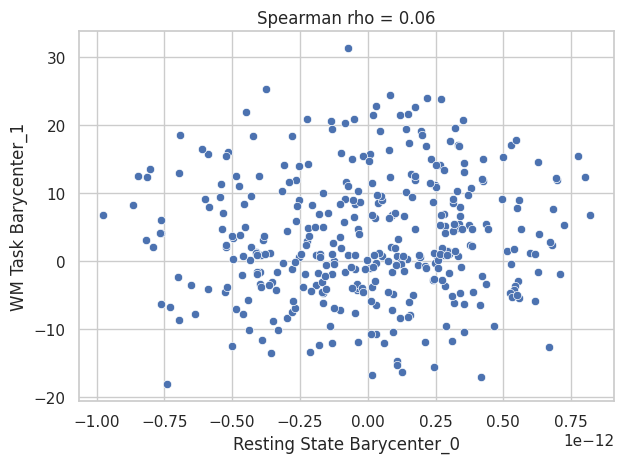

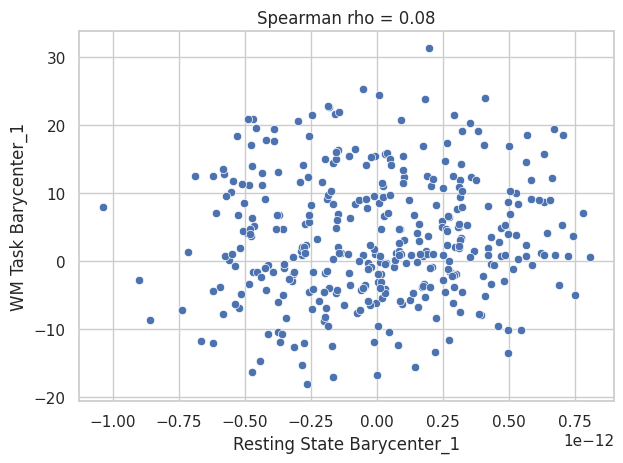

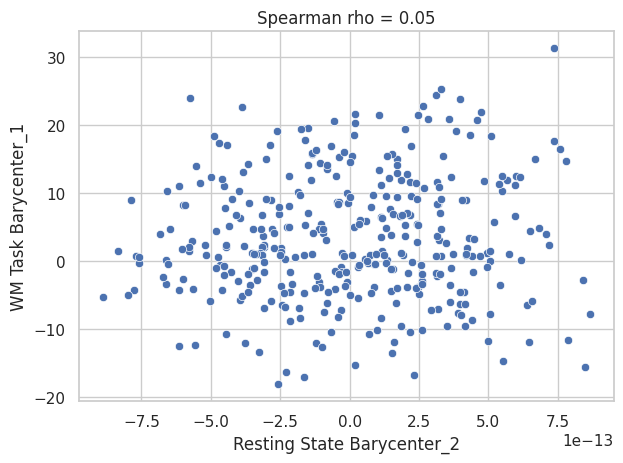

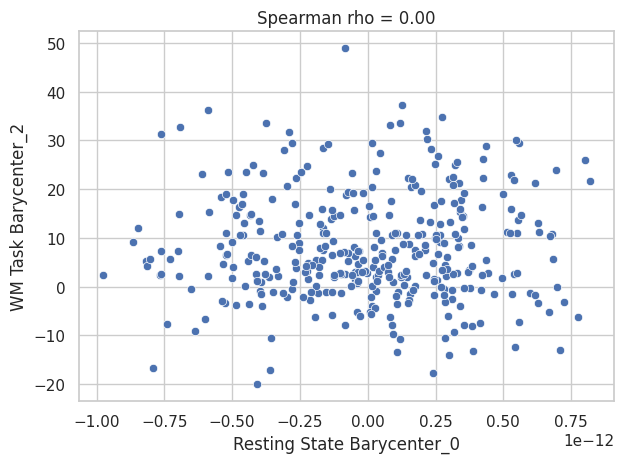

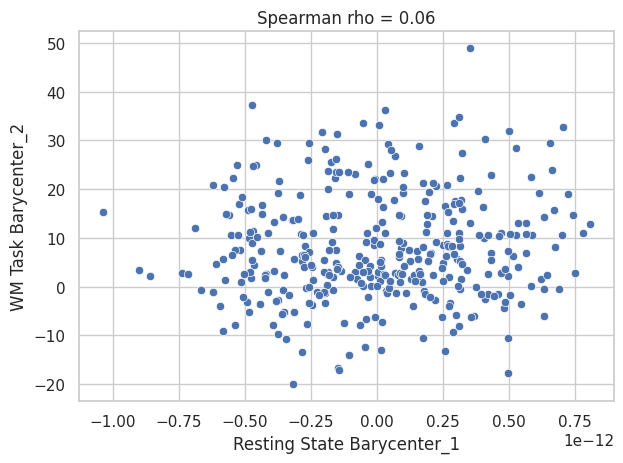

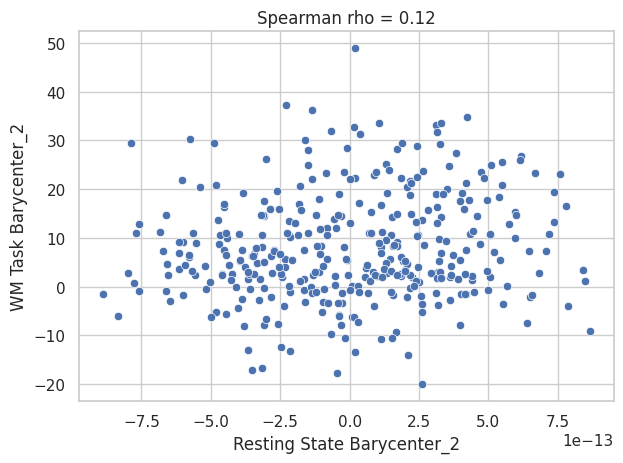

In [ ]:
import pandas as pd
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# Load barycenter data
wm_df = pd.read_csv("/content/csv_data/wm_task_barycenters_k3.csv", index_col="Parcel_ID")
rest_df = pd.read_csv("/content/csv_data/resting_state_barycenters_k3.csv", index_col="Parcel_ID")

# Ensure same parcel indices
if not wm_df.index.equals(rest_df.index):
    print("Parcel IDs don't match between WM and Rest files.")
    wm_df = wm_df.sort_index()
    rest_df = rest_df.sort_index()

# Compute Spearman correlations between each cluster pair
results = []
for i in range(wm_df.shape[1]):
    for j in range(rest_df.shape[1]):
        rho, pval = spearmanr(wm_df.iloc[:, i], rest_df.iloc[:, j])
        results.append({
            "WM_Cluster": f"Barycenter_{i}",
            "Rest_Cluster": f"Barycenter_{j}",
            "Spearman_rho": rho,
            "p_value": pval
        })

correlation_df = pd.DataFrame(results)
print(correlation_df)

# Optional: plot cluster-by-cluster scatter
sns.set(style="whitegrid")
for i in range(wm_df.shape[1]):
    for j in range(rest_df.shape[1]):
        sns.scatterplot(x=rest_df.iloc[:, j], y=wm_df.iloc[:, i])
        plt.xlabel(f"Resting State {rest_df.columns[j]}")
        plt.ylabel(f"WM Task {wm_df.columns[i]}")
        plt.title(f"Spearman rho = {correlation_df.iloc[i * 3 + j]['Spearman_rho']:.2f}")
        plt.tight_layout()
        plt.show()


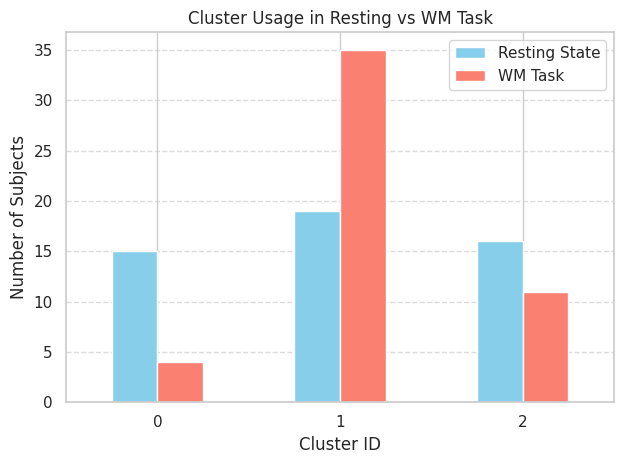

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
rest_df = pd.read_csv('/content/csv_data/subject_cluster_assignments_resting_state_k3.csv')
wm_df = pd.read_csv('/content/csv_data/subject_cluster_assignments_wm_task_k3.csv')

# The column names are already correct after loading the assignment files, so renaming is not strictly needed, but we can keep it for clarity.
rest_df.columns = ['Subject_ID', 'Cluster_ID_rest']
wm_df.columns = ['Subject_ID', 'Cluster_ID_wm']


# Merge the two datasets
merged_df = pd.merge(rest_df, wm_df, on='Subject_ID')

# Count frequency of clusters in each condition
rest_counts = merged_df['Cluster_ID_rest'].value_counts().sort_index()
wm_counts = merged_df['Cluster_ID_wm'].value_counts().sort_index()

# Combine counts into one DataFrame
cluster_usage = pd.DataFrame({
    'Resting State': rest_counts,
    'WM Task': wm_counts
}).fillna(0).astype(int)

# Barplot
cluster_usage.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Cluster Usage in Resting vs WM Task')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Subjects')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()